<a href="https://colab.research.google.com/github/Maithili-Badhan/Episodic-Memory-Benchmark-Evaulation-and-Model-Synthesis/blob/main/Qwen_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q /content/data.zip -d data

In [ ]:
import shutil, os

# Path to the nested redundant directory
nested_path = "data/episodic-memory-benchmark/epbench/data"

# Path to the correct target location
target_path = "data"

# Move all contents up
for item in os.listdir(nested_path):
    s = os.path.join(nested_path, item)
    d = os.path.join(target_path, item)
    if os.path.exists(d):
        print(f"Skipping {item}, already exists at target")
    else:
        shutil.move(s, d)

# Remove the now-empty redundant folders
shutil.rmtree("data/episodic-memory-benchmark")

# Generated Story Book Evaluation

Detected 50 chapters from TXT.

Top Detected Characters:
  As (158 mentions)
  Zoe (17 mentions)
  With (16 mentions)
  Their (15 mentions)
  Henry (15 mentions)
  Julian (13 mentions)
  His (12 mentions)
  Mila (12 mentions)
  September (10 mentions)
  Owen (9 mentions)
  Henry Reed (8 mentions)
  Something (8 mentions)
  October (8 mentions)
  Her (8 mentions)
  When (7 mentions)
  Yet (7 mentions)
  High Line (7 mentions)
  This (7 mentions)
  Samuel (7 mentions)
  May (6 mentions)


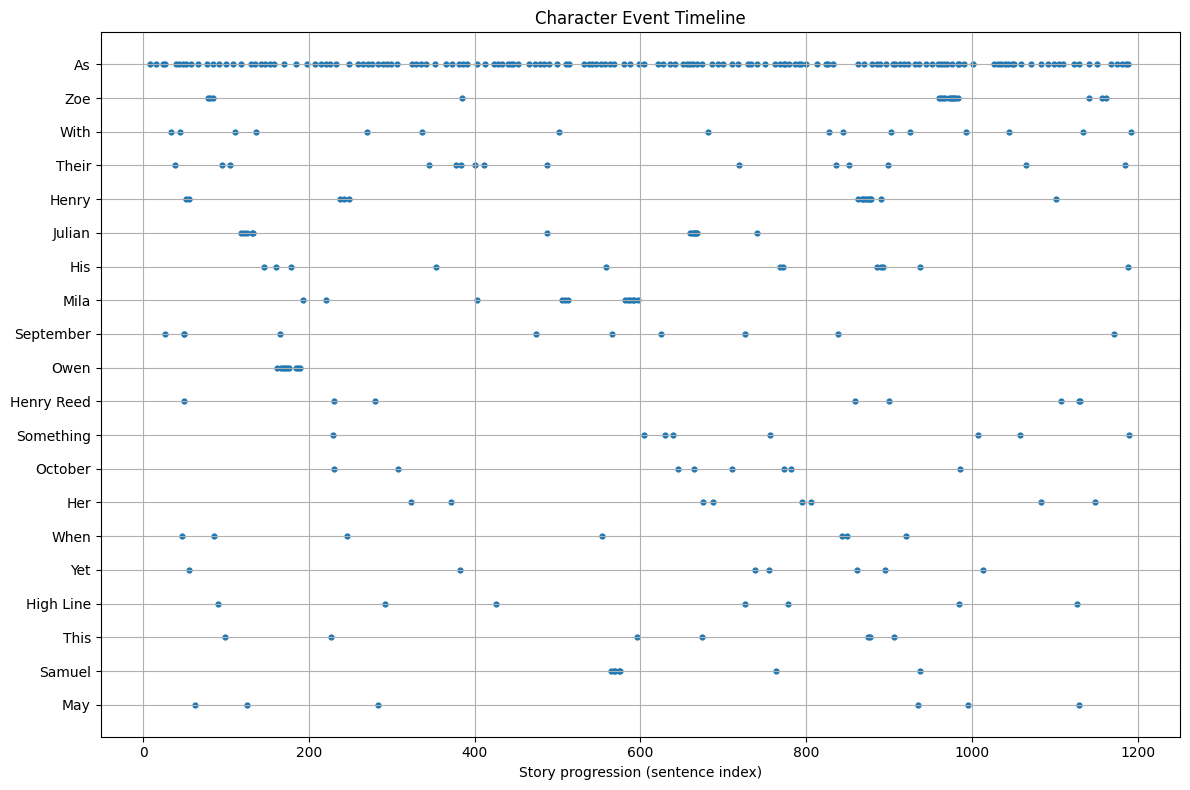


Saved files:
/content/story_analysis/character_summary.csv
/content/story_analysis/character_timeline.png
/content/story_analysis/places_counts.csv
/content/story_analysis/entities_counts.csv


In [ ]:
# === Cell: Extract characters, places, and build a character event timeline (TXT version) ===

import os, re, glob
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------
# CONFIG
# -------------------------------------------------------
INPUT_TXT = "/content/output_book.txt"     # Change if file name differs
OUTPUT_DIR = "/content/story_analysis"     # Safe directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

MIN_MENTIONS = 2          # minimum # of times a name appears to count as character
TOP_CHAR_PLOT = 20        # number of characters to plot timeline for

# -------------------------------------------------------
# HELPER REGEX
# -------------------------------------------------------
chapter_re = re.compile(r"^\s*Chapter\s+(\w+)", re.I)

_sent_split_re = re.compile(r'(?<=[.!?])\s+')
_proper_seq_re = re.compile(r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,2})\b')

_year_re = re.compile(r'\b(1[89]\d{2}|20\d{2})\b')
_month_name_re = re.compile(
    r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b',
    re.I
)
_month_day_re = re.compile(
    r'\b(?:\d{1,2}(?:st|nd|rd|th)?\s+)?'
    r'(January|February|March|April|May|June|July|August|September|October|November|December)'
    r'\s+\d{1,2}(?:st|nd|rd|th)?(?:,?\s*\d{4})?\b',
    re.I
)

_place_re = re.compile(r'\b(?:in|at|on|to|near|from|towards)\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b')

_ignore_set = {
    "The","A","An","It","He","She","They","We","I","In","On","At","From","To","Of","And","But",
    "If","However","Chapter","Scene","Act","Prologue","Epilogue","Figure","Table"
}
_ignore_lower = {w.lower() for w in _ignore_set}

# -------------------------------------------------------
# LOAD TXT
# -------------------------------------------------------
if not os.path.exists(INPUT_TXT):
    raise FileNotFoundError(f"TXT file not found at {INPUT_TXT}. Upload output_book.txt first.")

with open(INPUT_TXT, "r", encoding="utf-8") as f:
    raw_text = f.read()

# -------------------------------------------------------
# SPLIT INTO CHAPTERS BASED ON "Chapter X"
# -------------------------------------------------------
lines = raw_text.splitlines()
chapters = []
current_chapter = {"id": "0", "text": ""}

for line in lines:
    chap_match = chapter_re.match(line)
    if chap_match:
        if current_chapter["text"].strip():
            chapters.append(current_chapter)
        chap_num = chap_match.group(1)
        current_chapter = {"id": chap_num, "text": ""}
    else:
        current_chapter["text"] += line + "\n"

# add final chapter
if current_chapter["text"].strip():
    chapters.append(current_chapter)

print(f"Detected {len(chapters)} chapters from TXT.")

# -------------------------------------------------------
# EXTRACTION HELPERS
# -------------------------------------------------------
def split_sentences(text):
    text = re.sub(r'\s+', ' ', text).strip()
    if not text: return []
    return [s.strip() for s in _sent_split_re.split(text) if s.strip()]

def extract_proper_nouns(sentence):
    cands = _proper_seq_re.findall(sentence)
    out = []
    for cand in cands:
        first = cand.split()[0]
        if first in _ignore_set or first.lower() in _ignore_lower:
            continue
        out.append(cand.strip())
    return out

def extract_dates(sentence):
    dates = []
    for m in _month_day_re.finditer(sentence): dates.append(m.group(0))
    for m in _year_re.finditer(sentence): dates.append(m.group(1))
    for m in _month_name_re.finditer(sentence): dates.append(m.group(1))
    return dates

def extract_places(sentence):
    return [m.group(1).strip() for m in _place_re.finditer(sentence)]

# -------------------------------------------------------
# EXTRACT CHARACTER EVENTS
# -------------------------------------------------------
char_events = defaultdict(list)
char_counts = Counter()
place_counts = Counter()
all_entities = Counter()

global_sentence_index = 0

for ch_idx, ch in enumerate(chapters):
    chap_id = ch["id"]
    sentences = split_sentences(ch["text"])
    for s_idx, sent in enumerate(sentences):
        global_sentence_index += 1
        names = extract_proper_nouns(sent)
        dates = extract_dates(sent)
        places = extract_places(sent)

        for n in names:
            evt = {
                "chapter_id": chap_id,
                "chapter_index": ch_idx,
                "sentence_index_in_chapter": s_idx,
                "global_sentence_index": global_sentence_index,
                "sentence": sent,
                "dates": dates,
                "places": places
            }
            char_events[n].append(evt)
            char_counts[n] += 1
            all_entities[n] += 1

        for pl in places:
            place_counts[pl] += 1

# -------------------------------------------------------
# FILTER CHARACTER CANDIDATES
# -------------------------------------------------------
character_list = [
    n for n,count in char_counts.items() if count >= MIN_MENTIONS
]

character_list = sorted(character_list, key=lambda x: -char_counts[x])

print("\nTop Detected Characters:")
for c in character_list[:20]:
    print(f"  {c} ({char_counts[c]} mentions)")

# -------------------------------------------------------
# CHARACTER SUMMARY TABLE
# -------------------------------------------------------
rows = []
for name in character_list:
    events = char_events[name]
    first_evt = min(events, key=lambda e: e["global_sentence_index"])
    last_evt = max(events, key=lambda e: e["global_sentence_index"])

    places = set(p for e in events for p in e["places"])
    dates = set(d for e in events for d in e["dates"])

    rows.append({
        "character": name,
        "mentions": len(events),
        "first_chapter": first_evt["chapter_id"],
        "last_chapter": last_evt["chapter_id"],
        "num_places": len(places),
        "num_dates": len(dates),
        "sample_sentence": events[0]["sentence"][:200]
    })

summary_df = pd.DataFrame(rows)
summary_csv = os.path.join(OUTPUT_DIR, "character_summary.csv")
summary_df.to_csv(summary_csv, index=False)

# -------------------------------------------------------
# TIMELINE PLOT
# -------------------------------------------------------
plot_chars = character_list[:min(TOP_CHAR_PLOT, len(character_list))]
char_to_y = {name:i for i,name in enumerate(reversed(plot_chars))}

xs = []
ys = []

for name in plot_chars:
    for evt in char_events[name]:
        xs.append(evt["global_sentence_index"])
        ys.append(char_to_y[name])

plt.figure(figsize=(12, max(4, len(plot_chars)*0.4)))
plt.scatter(xs, ys, s=12)
plt.yticks(list(char_to_y.values()), list(reversed(plot_chars)))
plt.xlabel("Story progression (sentence index)")
plt.title("Character Event Timeline")
plt.grid(True)

timeline_path = os.path.join(OUTPUT_DIR, "character_timeline.png")
plt.tight_layout()
plt.savefig(timeline_path)
plt.show()

# -------------------------------------------------------
# SAVE OTHER TABLES
# -------------------------------------------------------
places_df = pd.DataFrame([{"place":p, "count":c} for p,c in place_counts.items()])
entities_df = pd.DataFrame([{"entity":e, "count":c} for e,c in all_entities.items()])

places_df.to_csv(os.path.join(OUTPUT_DIR, "places_counts.csv"), index=False)
entities_df.to_csv(os.path.join(OUTPUT_DIR, "entities_counts.csv"), index=False)

print("\nSaved files:")
print(summary_csv)
print(timeline_path)
print(os.path.join(OUTPUT_DIR, "places_counts.csv"))
print(os.path.join(OUTPUT_DIR, "entities_counts.csv"))

# Sending the book to Qwen and producing events JSONS

In [ ]:
# Install dependencies
# NOTE: restart runtime if prompted (colab may ask). Use GPU runtime.
!pip install -q transformers accelerate bitsandbytes safetensors sentencepiece
# optional faster tokenizer
!pip install -q "huggingface_hub>=0.17.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.2 MB/s eta 0:00:00


In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
# If you want to use generate() with streaming, later you can add use_cache etc.

# Model repo (Hugging Face)
MODEL_NAME = "Qwen/Qwen3-4B"  # or "Qwen/Qwen3-4B" (check HF)

# Safety: ensure we have GPU
if not torch.cuda.is_available():
    print("WARNING: no GPU found. Model will be VERY slow or may not load.")
else:
    print("CUDA device count:", torch.cuda.device_count(), "Name:", torch.cuda.get_device_name(0))

# Load tokenizer (some models need trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False, trust_remote_code=True)

# Load model with quantization (bitsandbytes) and automatic device map
# This requires bitsandbytes installed and a CUDA-enabled GPU.
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    torch_dtype=torch.float16,   # model params in fp16 where possible
    device_map="auto",
    load_in_4bit=True            # 4-bit quantization via bitsandbytes
)

# Move model to GPU if device_map didn't do that automatically
# (device_map="auto" should place layers on GPU if available)
print("Model loaded. Model dtype:", next(model.parameters()).dtype)

CUDA device count: 1 Name: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Model loaded. Model dtype: torch.float16


In [ ]:
# === Cell: Chunk output_book.txt and send chunks to LOCAL Qwen model ===

import os, json, re, time
from pathlib import Path
from tqdm import tqdm
import torch

# ---------- CONFIG ----------
INPUT_TXT = "/content/output_book.txt"
OUTPUT_DIR = "/content/qwen_run_outputs_local"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# chunking config
CHUNK_SIZE = 2000
CHUNK_OVERLAP = 200
MAX_NEW_TOKENS = 512       # adjust if needed
TEMPERATURE = 0.0

# Output folder
PER_CHUNK_DIR = os.path.join(OUTPUT_DIR, "qwen_chunks")
os.makedirs(PER_CHUNK_DIR, exist_ok=True)
MERGED_JSON = os.path.join(OUTPUT_DIR, "qwen_book_contexts.json")

# ---------- Require local model already loaded ----------
try:
    model
    tokenizer
except NameError:
    raise RuntimeError("ERROR: You must load the Qwen model first in a previous cell!")

device = model.device

# ---------- utils ----------
def read_text(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    if not text:
        return []
    chunks = []
    i = 0
    L = len(text)
    while i < L:
        end = min(i + chunk_size, L)
        chunks.append(text[i:end])
        if end >= L:
            break
        i = end - overlap
    return chunks

# ---------- prompt template ----------
PROMPT_TEMPLATE = """
You are a precise extractor preparing story context for question answering.
INPUT: a passage from a story.
TASK: return ONLY valid JSON with keys:
  - "summary": 2-3 sentence summary.
  - "entities": list of entity strings (max 20)
  - "events": list of event objects with keys:
        "time", "location", "characters", "brief"
  - "confidence": "low" | "medium" | "high"

If nothing found, return empty arrays.

Passage:
\"\"\"{passage}\"\"\"
"""

# ---------- run generation ----------
def generate_local(text):
    """Run local Qwen model with safe settings."""
    input_ids = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=4096
    ).to(device)

    output_ids = model.generate(
        **input_ids,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=TEMPERATURE,
        do_sample=False
    )
    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return decoded

# ---------- main ----------
if not Path(INPUT_TXT).exists():
    raise FileNotFoundError(f"Missing: {INPUT_TXT}")

full_text = read_text(INPUT_TXT)
chunks = chunk_text(full_text)
print(f"Full text: {len(full_text)} chars → {len(chunks)} chunks")

results = []

for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks locally")):
    prompt = PROMPT_TEMPLATE.format(passage=chunk)
    try:
        model_output = generate_local(prompt)

        # attempt direct JSON load
        try:
            parsed = json.loads(model_output.strip())
        except:
            # extract first JSON block
            m = re.search(r'(\{[\s\S]*?\})', model_output, re.DOTALL)
            if m:
                try:
                    parsed = json.loads(m.group(1))
                except:
                    parsed = {"raw": model_output}
            else:
                parsed = {"raw": model_output}

        chunk_result = {
            "chunk_index": i,
            "chunk_text_len": len(chunk),
            "model_raw": model_output,
            "model_json": parsed
        }
    except Exception as e:
        chunk_result = {
            "chunk_index": i,
            "chunk_text_len": len(chunk),
            "error": str(e)
        }

    # save per-chunk file
    with open(os.path.join(PER_CHUNK_DIR, f"chunk_{i:03d}.json"), "w", encoding="utf-8") as f:
        json.dump(chunk_result, f, ensure_ascii=False, indent=2)

    results.append(chunk_result)

# merged JSON
with open(MERGED_JSON, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("\nDONE!")
print("Per-chunk JSONs →", PER_CHUNK_DIR)
print("Merged context →", MERGED_JSON)

Full text: 132412 chars → 74 chunks


Processing chunks locally: 100%|██████████| 74/74 [58:26<00:00, 47.38s/it]


DONE!
Per-chunk JSONs → /content/qwen_run_outputs_local/qwen_chunks
Merged context → /content/qwen_run_outputs_local/qwen_book_contexts.json


# Running the 3 sets of Questions

In [ ]:
# === Cell: Send questions to LOCAL Qwen model (direct prompting + RAG via TF-IDF) ===

import os, json, re, glob, time
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# ---------- CONFIG ----------
INPUT_TXT = "/content/output_book.txt"
CHUNKS_DIR = "/content/qwen_run_outputs/qwen_chunks"   # existing per-chunk JSONs (if any)
MERGED_JSON = "/content/qwen_run_outputs/qwen_book_contexts.json"

OUTPUT_DIR = "/content/qwen_run_outputs/questions_run_local"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MAX_NEW_TOKENS = 512
TEMPERATURE = 0.0

# retrieval & prompt settings
TOP_K_PROMPT = 3   # number of chunks to attach for the "direct prompt" approach
TOP_K_RAG = 4      # number of chunks to retrieve for RAG
CHUNK_SIZE = 2000
CHUNK_OVERLAP = 200

# ---------- REQUIRE model and tokenizer ----------
# Assumes you already ran your model-loading cell:
# tokenizer = AutoTokenizer.from_pretrained(...)
# model = AutoModelForCausalLM.from_pretrained(...)

try:
    tokenizer  # exist check
    model
except NameError:
    raise RuntimeError("`model` and `tokenizer` must already be loaded in the environment. Load them first and re-run this cell.")

# Device determination
try:
    model_device = next(model.parameters()).device
except Exception:
    model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using local model on device:", model_device)

# ---------- Helpers: chunking / loading chunks ----------
def read_text(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def chunk_text_simple(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    if not text:
        return []
    chunks = []
    i = 0
    L = len(text)
    while i < L:
        end = min(i + chunk_size, L)
        chunks.append(text[i:end])
        if end >= L:
            break
        i = end - overlap
    return chunks

def load_chunks_from_dir(chunks_dir):
    files = sorted(glob.glob(os.path.join(chunks_dir, "*.json")))
    chunks = []
    for fp in files:
        try:
            with open(fp, "r", encoding="utf-8") as f:
                j = json.load(f)
            # prefer explicit chunk text fields if present; otherwise fallback to model_raw (less ideal)
            text = j.get("chunk_text") or j.get("chunk") or j.get("original_text") or j.get("context_text") or j.get("model_raw","")
            chunks.append({"file": os.path.basename(fp), "json": j, "text": text})
        except Exception:
            continue
    return [c for c in chunks if c["text"]]

def ensure_chunks():
    # prefer merged JSON then per-chunk dir; else chunk the raw TXT
    if os.path.exists(MERGED_JSON):
        try:
            with open(MERGED_JSON, "r", encoding="utf-8") as f:
                merged = json.load(f)
            texts = []
            for item in merged:
                if item.get("chunk_text"):
                    texts.append(item["chunk_text"])
                elif item.get("raw_chunk_text"):
                    texts.append(item["raw_chunk_text"])
            if texts:
                return texts
        except Exception:
            pass

    if os.path.isdir(CHUNKS_DIR):
        chunks = load_chunks_from_dir(CHUNKS_DIR)
        if chunks:
            return [c["text"] for c in chunks]

    if os.path.exists(INPUT_TXT):
        full = read_text(INPUT_TXT)
        return chunk_text_simple(full)
    raise FileNotFoundError("No chunk data or input text found. Run the chunking cell first or upload output_book.txt.")

# ---------- local generate function (wrap model.generate) ----------
def safe_truncate_tokens(prompt, max_total_length):
    model_max = getattr(tokenizer, "model_max_length", None)
    if model_max is None:
        model_max = 8192
    allowed = min(model_max, max_total_length)
    return allowed

def generate_local(prompt, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE):
    allowed = safe_truncate_tokens(prompt, max_total_length=4096)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=allowed)
    # Move tensors to model device
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    gen_kwargs = dict(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=temperature,
        output_attentions=False,
        output_hidden_states=False
    )
    with torch.no_grad():
        out_ids = model.generate(**gen_kwargs)
    decoded = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    return decoded

# ---------- Prepare chunk_texts & TF-IDF index ----------
chunk_texts = ensure_chunks()
print(f"Loaded {len(chunk_texts)} chunks for retrieval/prompting.")

tfidf_vec = None
tfidf_X = None
try:
    tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=50000)
    tfidf_X = tfidf_vec.fit_transform(chunk_texts)
    print("Built TF-IDF index.")
except Exception as e:
    print("TF-IDF index build failed:", e)
    tfidf_vec = tfidf_X = None

# ---------- Prompt templates ----------
PROMPT_DIRECT_TEMPLATE = """
You are a precise QA assistant. Use ONLY the provided CONTEXT (do not hallucinate beyond it).
CONTEXT:
{context}

QUESTION:
{question}

Answer concisely. If the answer is not present in the CONTEXT, respond exactly: NOT_IN_CONTEXT
Return the answer as plain text only.
"""

PROMPT_RAG_TEMPLATE = """
You are a precise QA assistant using retrieved context. Use ONLY the CONTEXT pieces below to answer the question.
CONTEXT:
{context}

QUESTION:
{question}

If the context doesn't contain the answer, reply: NOT_IN_CONTEXT
Return the answer as plain text only.
"""

def keyword_score_select(question, chunk_texts, top_k=3):
    q_tokens = re.findall(r"\w+", question.lower())
    scores = []
    for i, t in enumerate(chunk_texts):
        low = t.lower()
        score = sum(1 for tok in q_tokens if tok and tok in low)
        scores.append((score, i))
    scores.sort(reverse=True)
    selected_idx = [idx for score, idx in scores[:top_k]]
    return selected_idx

def tfidf_retrieve(query, vec, X, top_k=4):
    qv = vec.transform([query])
    scores = (X @ qv.T).toarray().ravel()
    idxs = np.argsort(-scores)[:top_k]
    return idxs, scores[idxs]

# ---------- Processing each question CSV ----------
QUESTION_CSV_PATHS = ["/content/qset3.csv"]

print("Question CSVs to process:", QUESTION_CSV_PATHS)

for qpath in QUESTION_CSV_PATHS:
    if not os.path.exists(qpath):
        print("Skipping missing:", qpath); continue
    qdf = pd.read_csv(qpath)
    cols_lower = {c.lower(): c for c in qdf.columns}
    qcol = None
    for candidate in ("question", "ques", "q", "text"):
        if candidate in cols_lower:
            qcol = cols_lower[candidate]; break
    if qcol is None:
        qcol = qdf.columns[1] if len(qdf.columns)>1 else qdf.columns[0]
    idcol = None
    for candidate in ("sl no","sl","id","index","sno","sr.no","s_no"):
        if candidate in cols_lower:
            idcol = cols_lower[candidate]; break
    if idcol is None:
        idcol = qdf.columns[0]

    results_direct = []
    results_rag = []

    print(f"\nProcessing questions file: {qpath} ({len(qdf)} questions)")
    for ridx, row in tqdm(qdf.iterrows(), total=len(qdf), desc=f"Questions in {os.path.basename(qpath)}"):
        qid = row[idcol] if idcol in row else ridx
        question = str(row[qcol])

        # ---------- DIRECT prompting: keyword selection ----------
        sel_idxs = keyword_score_select(question, chunk_texts, top_k=TOP_K_PROMPT)
        context_direct = "\n\n---\n\n".join(chunk_texts[i] for i in sel_idxs) if sel_idxs else ""
        prompt_direct = PROMPT_DIRECT_TEMPLATE.format(context=context_direct, question=question)
        try:
            text_direct = generate_local(prompt_direct, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE)
            if prompt_direct.strip() in text_direct:
                text_direct = text_direct.split(prompt_direct.strip())[-1].strip()
        except Exception as e:
            text_direct = f"LOCAL_MODEL_ERROR: {e}"
        results_direct.append({"id": qid, "question": question, "answer": text_direct, "selected_chunk_idxs": sel_idxs})

        # ---------- RAG prompting: TF-IDF retrieval ----------
        # ensure scores_list is always explicitly set (avoid leaking numpy arrays between iterations)
        scores_list = None
        if tfidf_vec is not None and tfidf_X is not None:
            idxs, scores = tfidf_retrieve(question, tfidf_vec, tfidf_X, top_k=TOP_K_RAG)
            # convert numpy array -> regular list for JSON serialization
            if isinstance(scores, np.ndarray):
                scores_list = scores.tolist()
            else:
                # if scores is a scalar or list-like, make sure to convert
                try:
                    scores_list = list(scores)
                except Exception:
                    scores_list = None
            context_rag = "\n\n---\n\n".join(chunk_texts[i] for i in idxs)
        else:
            idxs = keyword_score_select(question, chunk_texts, top_k=TOP_K_RAG)
            context_rag = "\n\n---\n\n".join(chunk_texts[i] for i in idxs)

        prompt_rag = PROMPT_RAG_TEMPLATE.format(context=context_rag, question=question)
        try:
            text_rag = generate_local(prompt_rag, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE)
            if prompt_rag.strip() in text_rag:
                text_rag = text_rag.split(prompt_rag.strip())[-1].strip()
        except Exception as e:
            text_rag = f"LOCAL_MODEL_ERROR: {e}"

        results_rag.append({
            "id": qid,
            "question": question,
            "answer": text_rag,
            "retrieved_idxs": idxs,
            "retrieval_scores": scores_list
        })

    # ---------- Save outputs per CSV ----------
    base = os.path.splitext(os.path.basename(qpath))[0]
    direct_csv = os.path.join(OUTPUT_DIR, f"{base}_direct_answers.csv")
    rag_csv = os.path.join(OUTPUT_DIR, f"{base}_rag_answers.csv")
    pd.DataFrame(results_direct).to_csv(direct_csv, index=False)
    pd.DataFrame(results_rag).to_csv(rag_csv, index=False)

    # also save JSON raw
    with open(os.path.join(OUTPUT_DIR, f"{base}_direct_raw.json"), "w", encoding="utf-8") as f:
        json.dump(results_direct, f, ensure_ascii=False, indent=2)
    with open(os.path.join(OUTPUT_DIR, f"{base}_rag_raw.json"), "w", encoding="utf-8") as f:
        json.dump(results_rag, f, ensure_ascii=False, indent=2)

    print(f"Saved direct answers -> {direct_csv}")
    print(f"Saved RAG answers -> {rag_csv}")

print("\nAll done. Outputs saved in:", OUTPUT_DIR)

Using local model on device: cuda:0
Loaded 74 chunks for retrieval/prompting.
Built TF-IDF index.
Question CSVs to process: ['/content/qset3.csv']

Processing questions file: /content/qset3.csv (40 questions)


Questions in qset3.csv: 100%|██████████| 40/40 [1:10:39<00:00, 105.99s/it]


TypeError: Object of type ndarray is not JSON serializable

# Evaluating the Answers: LLM-as-a-Judge

Found answer files: ['/content/qset1_direct_answers.csv', '/content/qset1_rag_answers.csv', '/content/qset2_direct_answers.csv', '/content/qset2_rag_answers.csv', '/content/qset3_direct_answers.csv', '/content/qset3_rag_answers.csv']
Found question files: ['/content/qset1.csv', '/content/qset1_direct_answers.csv', '/content/qset1_rag_answers.csv', '/content/qset2.csv', '/content/qset2_direct_answers.csv', '/content/qset2_rag_answers.csv', '/content/qset3.csv', '/content/qset3_direct_answers.csv', '/content/qset3_rag_answers.csv']

Processing answers file: qset1_direct_answers method: direct
Saved per-question evaluation to: /content/eval_results/qset1_direct_answers_evaluation.csv

Processing answers file: qset1_rag_answers method: rag
Saved per-question evaluation to: /content/eval_results/qset1_rag_answers_evaluation.csv

Processing answers file: qset2_direct_answers method: direct
Saved per-question evaluation to: /content/eval_results/qset2_direct_answers_evaluation.csv

Processing

,answers_file,method,n_questions,mean_token_f1,mean_token_precision,mean_token_recall,pct_judge_correct
0,qset1_direct_answers.csv,direct,40,0.000000,0.000000,0.000,0.0
1,qset1_rag_answers.csv,rag,40,0.000000,0.000000,0.000,0.0
2,qset2_direct_answers.csv,direct,40,0.000538,0.000272,0.025,0.0
3,qset2_rag_answers.csv,rag,40,0.005556,0.002987,0.050,0.0
4,qset3_direct_answers.csv,direct,40,NaN,NaN,NaN,0.0
5,qset3_rag_answers.csv,rag,40,NaN,NaN,NaN,0.0


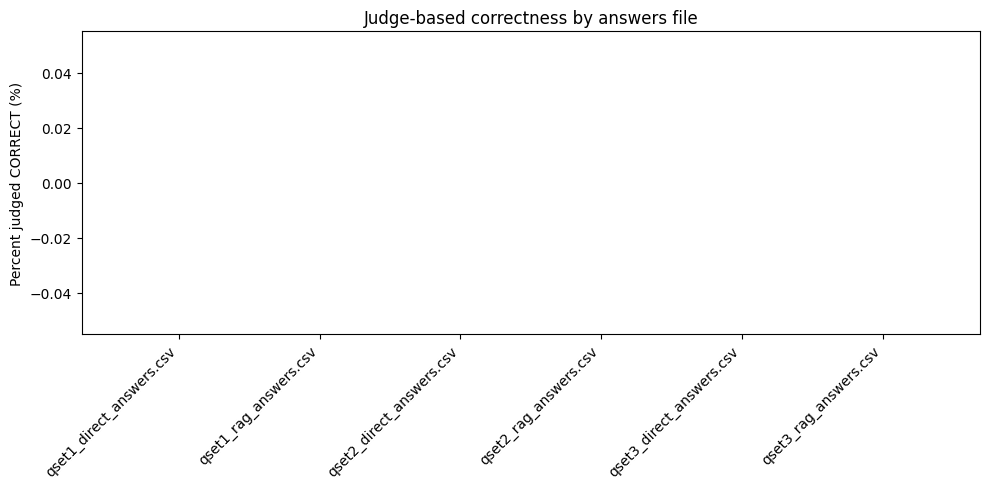

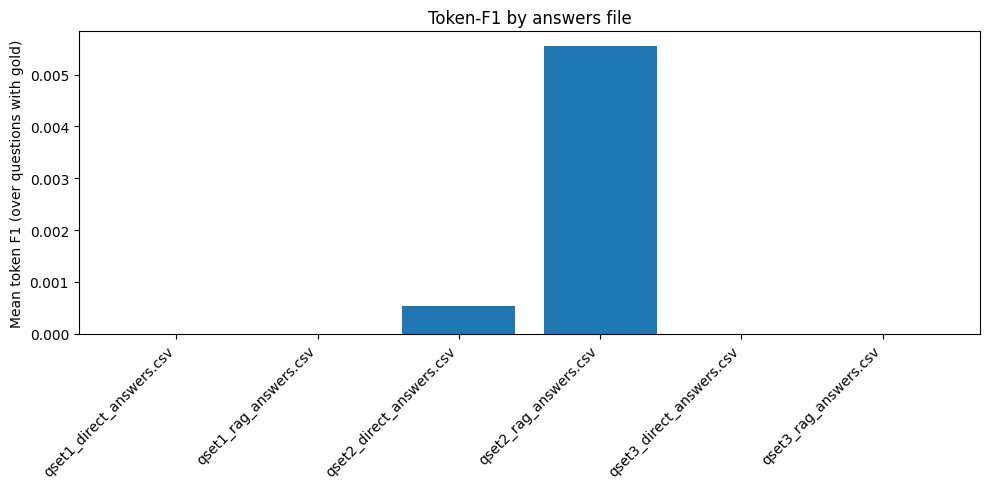

All eval outputs saved in: /content/eval_results
No image found at /mnt/data/de46492c-62dd-4cb1-a220-1d90950fc86d.png


In [ ]:
# === Minimal evaluation pipeline (no epbench) using meta-llama judge on OpenRouter ===
# Place this cell in Colab after your answer files and output_book.txt are present.

import os, glob, re, json, time, getpass
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageOps
import requests

# ---------------- CONFIG (edit if needed) ----------------
ANSWERS_DIR = "/content"   # where *_direct_answers.csv and *_rag_answers.csv live
QUESTIONS_DIR = "/content"                 # contains qset1.csv qset2.csv qset3.csv (adjusted)
BOOK_TXT = "/content/output_book.txt"
OUTPUT_DIR = "/content/eval_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Judge model (free on OpenRouter)
JUDGE_MODEL = "meta-llama/llama-3.1-70b-instruct"
OPENROUTER_BASE = "https://api.openrouter.ai/v1"
# --------------------------------------------------------


OPENROUTER_API_KEY = "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"

# ---------- helper: read book and prepare searchable windows ----------
if not os.path.exists(BOOK_TXT):
    raise FileNotFoundError(f"Book text not found at {BOOK_TXT} — place output_book.txt there.")

with open(BOOK_TXT, "r", encoding="utf-8") as f:
    book_raw = f.read()

# split book into paragraph windows for retrieval
paras = [p.strip() for p in re.split(r'\n{2,}', book_raw) if p.strip()]
# also create sliding windows of ~2000 chars (overlap 200)
windows = []
wsize = 2000
overlap = 200
for start in range(0, len(book_raw), wsize - overlap):
    windows.append(book_raw[start:start+wsize])
# merge and dedupe windows and paras
context_windows = list(dict.fromkeys(paras + windows))

def retrieve_contexts(question, top_k=3):
    qtokens = set(re.findall(r'\w+', question.lower()))
    scores = []
    for i, w in enumerate(context_windows):
        wt = w.lower()
        score = sum(1 for t in qtokens if t and t in wt)
        scores.append((score, i))
    scores.sort(reverse=True)
    selected = [context_windows[i] for s,i in scores[:top_k] if s>0]
    # if no keyword match, fallback to first top_k windows (cover early chapters)
    if not selected:
        selected = context_windows[:top_k]
    return selected

# ---------- helper: OpenRouter call with backoff ----------
MAX_RETRIES = 4
def post_with_backoff(url, headers, payload):
    delay = 1.5
    for attempt in range(1, MAX_RETRIES+1):
        try:
            resp = requests.post(url, headers=headers, json=payload, timeout=120)
            if resp.status_code in (200,201):
                return resp.json()
            if resp.status_code in (429,500,502,503,504):
                time.sleep(delay); delay *= 2; continue
            resp.raise_for_status()
        except requests.RequestException as e:
            if attempt == MAX_RETRIES:
                raise
            time.sleep(delay); delay *= 2
    raise RuntimeError("OpenRouter max retries exhausted")

def call_judge_openrouter(prompt, model=JUDGE_MODEL, max_tokens=1024, temperature=0.0):
    url = f"{OPENROUTER_BASE}/completions"
    headers = {"Authorization": f"Bearer {OPENROUTER_API_KEY}", "Content-Type": "application/json"}
    payload = {"model": model, "prompt": prompt, "max_tokens": max_tokens, "temperature": temperature}
    res = post_with_backoff(url, headers, payload)
    # attempt to extract the textual output (OpenRouter shapes may vary)
    text = ""
    if isinstance(res, dict):
        if "choices" in res and len(res["choices"])>0:
            text = res["choices"][0].get("text") or res["choices"][0].get("output") or ""
        elif "output" in res:
            text = res["output"]
        else:
            text = json.dumps(res)
    else:
        text = str(res)
    return text

# ---------- judge prompt template ----------
JUDGE_PROMPT_TEMPLATE = '''
You are an expert evaluator. Given (A) GOLD (if provided), (B) the MODEL ANSWER, and (C) the provided BOOK CONTEXT, determine whether the MODEL ANSWER is:
- CORRECT (faithful and present in the book context or matches gold),
- INCORRECT (contradicted by the book or does not match gold),
- NOT_IN_CONTEXT (the book/context does not contain enough evidence to decide).

If GOLD is provided, evaluate the MODEL ANSWER against GOLD (precision/recall style) and also check whether the answer is supported by the BOOK CONTEXT.

Return ONLY valid JSON with keys:
- label: one of "CORRECT", "INCORRECT", "NOT_IN_CONTEXT"
- matched_items: list of short strings from the model answer that match gold/context (can be empty)
- missed_items: list of items from gold not found in model answer (if gold provided)
- extra_items: list of additional correct items in model answer not in gold (if any)
- explanation: short explanation (1-3 sentences)
If GOLD is not provided, omit matched_items/missed_items/extra_items or return them empty.
'''

# ---------- find answer CSV files and question CSVs ----------
answer_files = sorted(glob.glob(os.path.join(ANSWERS_DIR, "*_answers.csv")))
question_files = sorted(glob.glob(os.path.join(QUESTIONS_DIR, "qset*.csv")))

if not answer_files:
    raise FileNotFoundError(f"No answer CSVs found in {ANSWERS_DIR}.")
if not question_files:
    raise FileNotFoundError(f"No qset CSVs found in {QUESTIONS_DIR}.")

print("Found answer files:", answer_files)
print("Found question files:", question_files)

# ---------- utility: detect gold column in question CSV ----------
GOLD_COL_CANDIDATES = ['gold','reference','correct_answer','answer','ground_truth','groundtruth']

def find_gold_col(df):
    for c in df.columns:
        if c.lower() in GOLD_COL_CANDIDATES:
            return c
    # if there's a column explicitly named 'question' and another col, maybe second is gold
    other = [c for c in df.columns if c.lower() != 'question']
    if len(other) == 1:
        return other[0]
    return None

# ---------- utility: simple token-overlap metric (for quick F1) ----------
def tokenize_simple(s):
    return re.findall(r'\w+', (s or "").lower())

def compute_token_f1(pred, gold):
    pred_tokens = set(tokenize_simple(pred))
    gold_tokens = set(tokenize_simple(gold))
    if not gold_tokens:
        return {"precision": None, "recall": None, "f1": None}
    tp = len(pred_tokens & gold_tokens)
    prec = tp / len(pred_tokens) if pred_tokens else 0.0
    rec = tp / len(gold_tokens) if gold_tokens else 0.0
    if prec==0 and rec==0:
        f1 = 0.0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return {"precision": prec, "recall": rec, "f1": f1}

# ---------- main evaluation loop ----------
summary_rows = []
per_question_records = []

for ans_fp in answer_files:
    method = "unknown"
    if "_direct" in ans_fp:
        method = "direct"
    elif "_rag" in ans_fp:
        method = "rag"
    base = Path(ans_fp).stem
    print("\nProcessing answers file:", base, "method:", method)
    df_ans = pd.read_csv(ans_fp)
    # expect columns 'id' (or first col) and 'question' and 'answer' (or 'model_answer')
    # Normalize column names
    cols_lower = {c.lower():c for c in df_ans.columns}
    qcol = None
    acol = None
    idcol = None
    for cand in ['question','ques','q']:
        if cand in cols_lower: qcol = cols_lower[cand]; break
    for cand in ['answer','model_answer','response','output','generated_answer']:
        if cand in cols_lower: acol = cols_lower[cand]; break
    for cand in ['id','sl no','sno','index','idx']:
        if cand in cols_lower: idcol = cols_lower[cand]; break
    if qcol is None:
        # try second column as question
        qcol = df_ans.columns[1] if len(df_ans.columns)>1 else df_ans.columns[0]
    if acol is None:
        # try last column
        acol = df_ans.columns[-1]
    if idcol is None:
        idcol = df_ans.columns[0]

    # map questions file: try to match qset by base name (qset1 etc)
    # find matching question file by prefix
    qfile = None
    for qf in question_files:
        # match qset1 <-> qset1_direct_answers.csv etc
        if Path(qf).stem in base or Path(qf).stem in ans_fp:
            qfile = qf; break
    if qfile is None:
        # fallback: pick first question set
        qfile = question_files[0]

    qdf = pd.read_csv(qfile)
    gold_col = find_gold_col(qdf)
    # normalize question id mapping: try to join by question text if available
    # Build mapping from question text -> gold answer (if exists)
    gold_map = {}
    qdf_qcol = None
    for c in qdf.columns:
        if c.lower() in ('question','ques','q'):
            qdf_qcol = c; break
    if qdf_qcol is None:
        qdf_qcol = qdf.columns[0]
    if gold_col:
        for _, r in qdf.iterrows():
            gold_map[str(r[qdf_qcol]).strip()] = str(r[gold_col]) if not pd.isna(r[gold_col]) else ""
    else:
        # no gold; gold_map stays empty
        pass

    per_file_records = []
    correct_count = 0
    f1s = []
    precisions = []
    recalls = []
    total = 0

    for _, row in df_ans.iterrows():
        total += 1
        qtext = str(row[qcol]).strip() if qcol in row else ""
        ans_text = str(row[acol]) if (acol in row and not pd.isna(row[acol])) else ""
        qid = row[idcol] if idcol in row else None

        # compute simple token-overlap metrics if gold present
        gold_text = gold_map.get(qtext, None)
        token_metrics = {"precision": None, "recall": None, "f1": None}
        if gold_text is not None and gold_text != "":
            token_metrics = compute_token_f1(ans_text, gold_text)
            if token_metrics["f1"] is not None:
                f1s.append(token_metrics["f1"])
            if token_metrics["precision"] is not None:
                precisions.append(token_metrics["precision"])
            if token_metrics["recall"] is not None:
                recalls.append(token_metrics["recall"])

        # retrieve book contexts
        contexts = retrieve_contexts(qtext, top_k=3)
        context_for_prompt = "\n\n---\n\n".join(contexts)

        # assemble judge prompt (include GOLD if present)
        if gold_text:
            judge_prompt = JUDGE_PROMPT_TEMPLATE + "\nGOLD:\n" + gold_text + "\n\nMODEL_ANSWER:\n" + ans_text + "\n\nBOOK_CONTEXT:\n" + context_for_prompt + "\n\nReturn JSON only."
        else:
            judge_prompt = JUDGE_PROMPT_TEMPLATE + "\nMODEL_ANSWER:\n" + ans_text + "\n\nBOOK_CONTEXT:\n" + context_for_prompt + "\n\nReturn JSON only."

        # call judge
        try:
            judge_reply = call_judge_openrouter(judge_prompt, model=JUDGE_MODEL, max_tokens=512)
            # attempt parse JSON from reply (robust)
            parsed = None
            try:
                parsed = json.loads(judge_reply.strip())
            except Exception:
                m = re.search(r'(\{[\s\S]*\})', judge_reply)
                if m:
                    try:
                        parsed = json.loads(m.group(1))
                    except Exception:
                        parsed = {"raw": judge_reply}
                else:
                    parsed = {"raw": judge_reply}
        except Exception as e:
            parsed = {"raw": f"JUDGE_API_ERROR: {e}"}

        # interpret label
        label = parsed.get("label") if isinstance(parsed, dict) else None
        if not label:
            # try to infer from explanation or raw
            lab = None
            if isinstance(parsed, dict) and "explanation" in parsed:
                ex = str(parsed["explanation"]).lower()
                if "not in context" in ex or "no evidence" in ex:
                    lab = "NOT_IN_CONTEXT"
                elif "incorrect" in ex or "contradict" in ex:
                    lab = "INCORRECT"
                elif "correct" in ex or "matches" in ex or "supported" in ex:
                    lab = "CORRECT"
            if not lab:
                lab = "NOT_IN_CONTEXT"
            label = lab

        if label == "CORRECT":
            correct_count += 1

        rec = {
            "answers_file": os.path.basename(ans_fp),
            "method": method,
            "qid": qid,
            "question": qtext,
            "model_answer": ans_text,
            "gold": gold_text if gold_text else "",
            "precision_tok": token_metrics["precision"],
            "recall_tok": token_metrics["recall"],
            "f1_tok": token_metrics["f1"],
            "judge_raw": parsed,
            "judge_label": label
        }
        per_file_records.append(rec)
        per_question_records.append(rec)
        # small delay to avoid bursts (judge can be slow; tune if needed)
        time.sleep(0.2)

    # per-file metrics
    mean_f1 = np.mean(f1s) if f1s else None
    mean_prec = np.mean(precisions) if precisions else None
    mean_rec = np.mean(recalls) if recalls else None
    pct_judge_correct = correct_count / total * 100 if total>0 else None

    summary_rows.append({
        "answers_file": os.path.basename(ans_fp),
        "method": method,
        "n_questions": total,
        "mean_token_f1": mean_f1,
        "mean_token_precision": mean_prec,
        "mean_token_recall": mean_rec,
        "pct_judge_correct": pct_judge_correct
    })

    # save per-file detailed CSV/JSONL
    df_file_out = pd.DataFrame(per_file_records)
    out_csv = os.path.join(OUTPUT_DIR, f"{Path(ans_fp).stem}_evaluation.csv")
    df_file_out.to_json(out_csv.replace(".csv",".jsonl"), orient="records", lines=True)  # also save JSONL
    df_file_out.to_csv(out_csv, index=False)
    print("Saved per-question evaluation to:", out_csv)

# ---------- save overall summary and plots ----------
summary_df = pd.DataFrame(summary_rows)
summary_csv = os.path.join(OUTPUT_DIR, "evaluation_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("Saved summary CSV:", summary_csv)
display(summary_df)

# Bar plot: percent judged correct grouped by file
plt.figure(figsize=(10,5))
x = summary_df['answers_file']
y = summary_df['pct_judge_correct'].fillna(0)
plt.bar(x, y)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percent judged CORRECT (%)")
plt.title("Judge-based correctness by answers file")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "judge_correct_by_file.png"))
plt.show()

# If token-F1 available, plot mean token-F1
if summary_df['mean_token_f1'].notna().any():
    plt.figure(figsize=(10,5))
    plt.bar(summary_df['answers_file'], summary_df['mean_token_f1'].fillna(0))
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Mean token F1 (over questions with gold)")
    plt.title("Token-F1 by answers file")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "mean_token_f1_by_file.png"))
    plt.show()

print("All eval outputs saved in:", OUTPUT_DIR)

# ---------- display character timeline image (uploaded) ----------
IMAGE_PATH = "/mnt/data/de46492c-62dd-4cb1-a220-1d90950fc86d.png"
if os.path.exists(IMAGE_PATH):
    try:
        img = Image.open(IMAGE_PATH)
        img = ImageOps.contain(img, (900,900))
        display(img)
    except Exception as e:
        print("Could not display image:", e)
else:
    print("No image found at", IMAGE_PATH)

# Results


=== Summary used for plotting ===
            set_name  mean_token_f1_pct  pct_judge_correct_pct  chrono_awareness_pct  n_questions
qset1_direct_answers             0.0000                    0.0                   0.0           40
   qset1_rag_answers             0.0000                    0.0                   0.0           40
qset2_direct_answers             0.0538                    0.0                   0.0           40
   qset2_rag_answers             0.5556                    0.0                   0.0           40
qset3_direct_answers                NaN                    0.0                   NaN           40
   qset3_rag_answers                NaN                    0.0                   NaN           40


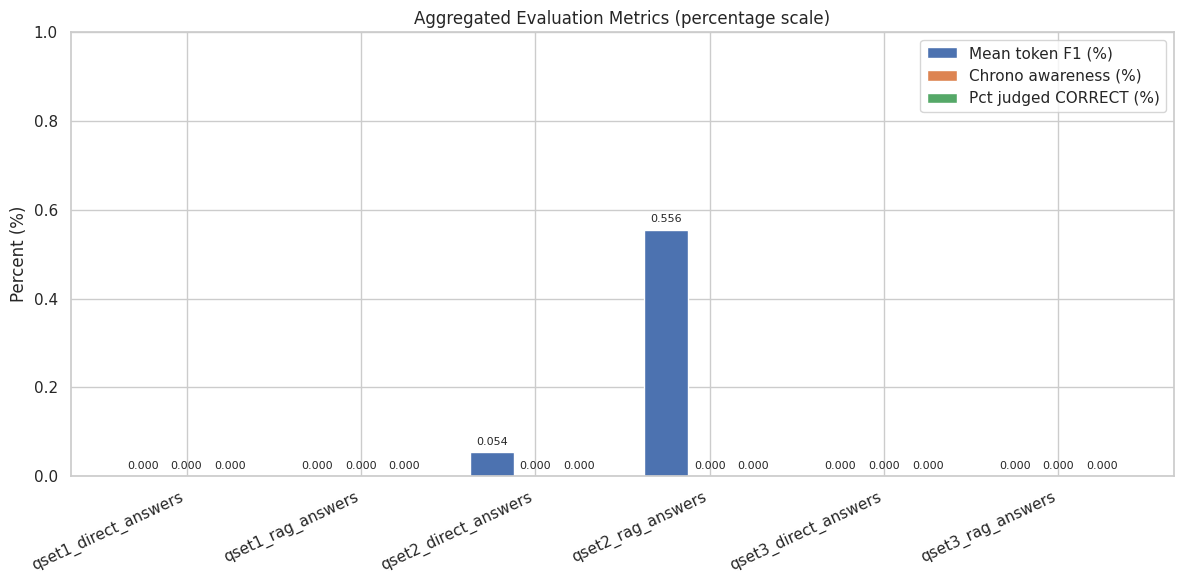


Saved plot to: /content/eval_results/aggregated_metrics_percent.png


In [ ]:
# --- visualize_eval_summary.py ---
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

EVAL_DIR = "/content/eval_results"   # adjust if different
SUMMARY_CSV = os.path.join(EVAL_DIR, "evaluation_summary.csv")

# --- helpers ---
def load_summary(summary_csv):
    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Summary CSV not found: {summary_csv}")
    s = pd.read_csv(summary_csv)
    # normalize columns
    s.columns = [c.lower().strip() for c in s.columns]
    return s

def load_per_file_eval(eval_dir):
    files = sorted(glob.glob(os.path.join(eval_dir, "*_evaluation.csv")))
    dfs = {}
    for fp in files:
        key = os.path.basename(fp).replace("_evaluation.csv", "")
        try:
            df = pd.read_csv(fp)
            df.columns = [c.lower().strip() for c in df.columns]
            dfs[key] = df
        except Exception as e:
            print("Could not read", fp, e)
    return dfs

def detect_chrono_questions(df):
    # conservative keyword-based heuristic for chronological questions
    chrono_keywords = ["before", "after", "first", "later", "earlier", "sequence", "subsequently", "order", "then"]
    if 'question' not in df.columns:
        return pd.Series([False]*len(df), index=df.index)
    qtexts = df['question'].astype(str).str.lower()
    mask = qtexts.apply(lambda q: any(kw in q for kw in chrono_keywords))
    return mask

# --- main combining logic ---
summary = load_summary(SUMMARY_CSV)
per_file = load_per_file_eval(EVAL_DIR)

# We'll fill a table with the three metrics we want to plot:
rows = []
for idx, row in summary.iterrows():
    answers_file = row.get('answers_file') or row.get('answers_file'.lower())
    # normalize file key to match per_file keys:
    key = os.path.splitext(os.path.basename(str(answers_file)))[0]
    # read from summary where available (these columns exist in your summary)
    mean_token_f1 = row.get('mean_token_f1', np.nan)
    pct_judge = row.get('pct_judge_correct', np.nan)
    # convert to percentages for better readability in plots
    mean_token_f1_pct = float(mean_token_f1) * 100 if pd.notna(mean_token_f1) else np.nan
    pct_judge_pct = float(pct_judge) * 100 if pd.notna(pct_judge) else np.nan

    # chrono: try to compute from per-question file if exists, else use a proxy
    chrono_awareness_pct = np.nan
    if key in per_file:
        dfq = per_file[key]
        # try to use f1_tok or mean_token_f1 fallback
        f1col = None
        for cand in ['f1_tok','f1','f1_score','mean_token_f1','mean_token_f1']:
            if cand in dfq.columns:
                f1col = cand; break
        # detect chrono rows
        chrono_mask = detect_chrono_questions(dfq)
        if chrono_mask.any() and f1col is not None:
            # compute mean f1 over chrono questions (convert to % if necessary)
            vals = pd.to_numeric(dfq.loc[chrono_mask, f1col], errors='coerce').dropna()
            if len(vals)>0:
                # if values are between 0 and 1, convert to %
                if vals.max() <= 1.0:
                    chrono_awareness_pct = vals.mean() * 100
                else:
                    chrono_awareness_pct = vals.mean()
    # if we couldn't compute chrono from the per-question data, fallback to mean_token_f1
    if np.isnan(chrono_awareness_pct) and pd.notna(mean_token_f1):
        chrono_awareness_pct = float(mean_token_f1) * 100

    rows.append({
        'set_name': key,
        'mean_token_f1_pct': mean_token_f1_pct,
        'pct_judge_correct_pct': pct_judge_pct,
        'chrono_awareness_pct': chrono_awareness_pct,
        'n_questions': int(row.get('n_questions', 0))
    })

plot_df = pd.DataFrame(rows)

# If some values are NaN, replace with 0 for plotting but keep NaN for printout
plot_df_fill = plot_df.fillna(0)

print("\n=== Summary used for plotting ===")
print(plot_df.round(4).to_string(index=False))

# --- plotting: grouped bar with annotations ---
labels = plot_df_fill['set_name'].tolist()
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
b1 = ax.bar(x - width, plot_df_fill['mean_token_f1_pct'], width, label='Mean token F1 (%)')
b2 = ax.bar(x, plot_df_fill['chrono_awareness_pct'], width, label='Chrono awareness (%)')
b3 = ax.bar(x + width, plot_df_fill['pct_judge_correct_pct'], width, label='Pct judged CORRECT (%)')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=25, ha='right')
ax.set_ylabel('Percent (%)')
ax.set_title('Aggregated Evaluation Metrics (percentage scale)')
ax.set_ylim(0, max(1.0, plot_df_fill[['mean_token_f1_pct','chrono_awareness_pct','pct_judge_correct_pct']].max().max() * 1.2))

# annotate tiny values so they are visible
def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 4), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(b1); annotate_bars(b2); annotate_bars(b3)
ax.legend()
plt.tight_layout()

OUT_PNG = os.path.join(EVAL_DIR, "aggregated_metrics_percent.png")
plt.savefig(OUT_PNG, dpi=200)
plt.show()

print("\nSaved plot to:", OUT_PNG)

Reference paper (local path): /mnt/data/2501.13121v1 Episodic Memory research paper.pdf


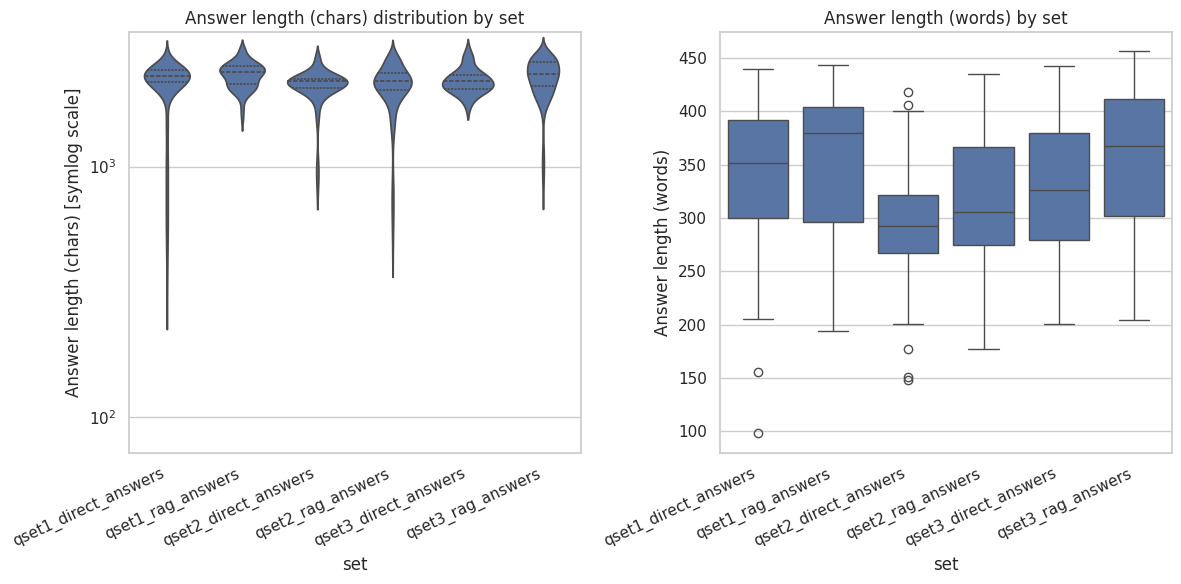

Saved: /content/eval_results/answer_length_distributions.png


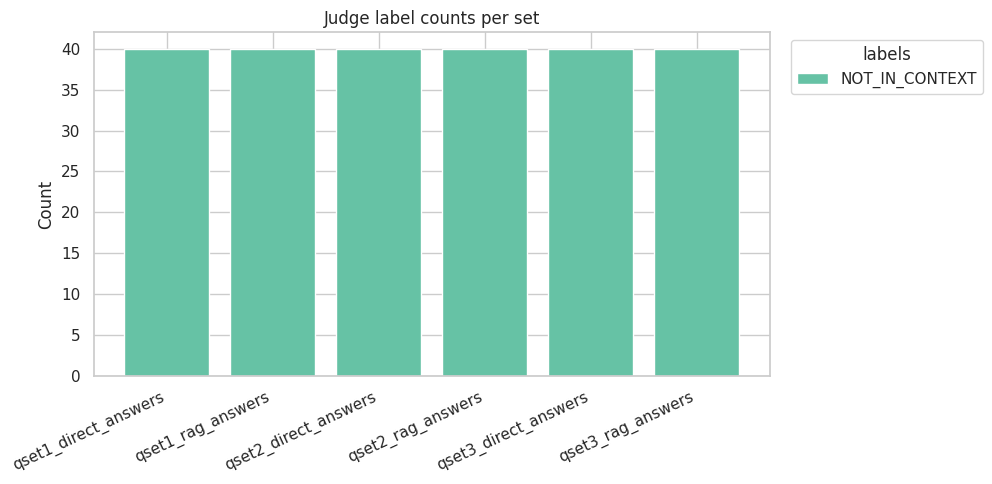

Saved: /content/eval_results/judge_label_counts_per_set.png


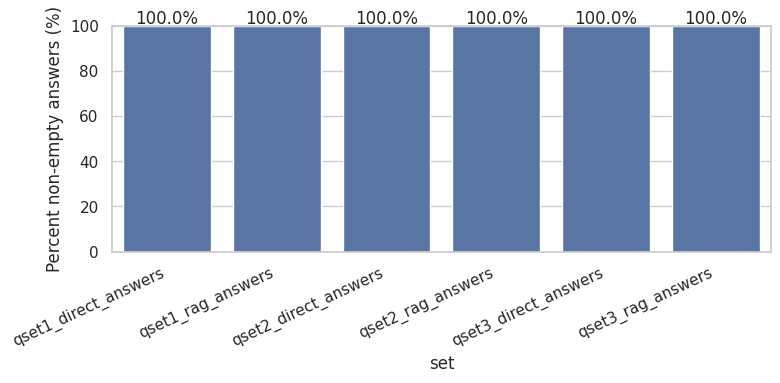

Saved: /content/eval_results/percent_nonempty_answers.png


In [ ]:
# ===== extra_visuals.py =====
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

EVAL_DIR = "/content/eval_results"   # same folder you used before
OUT_DIR = EVAL_DIR
os.makedirs(OUT_DIR, exist_ok=True)

# path to uploaded paper (as requested)
PAPER_PDF_PATH = "/mnt/data/2501.13121v1 Episodic Memory research paper.pdf"
print("Reference paper (local path):", PAPER_PDF_PATH)

# load per-file evaluation CSVs (those produced earlier)
files = sorted(glob.glob(os.path.join(EVAL_DIR, "*_evaluation.csv")))
if not files:
    raise FileNotFoundError(f"No evaluation CSVs found in {EVAL_DIR}")

dfs = {}
for fp in files:
    key = os.path.basename(fp).replace("_evaluation.csv", "")
    df = pd.read_csv(fp)
    # normalize lower-case columns for safe access
    df.columns = [c.lower().strip() for c in df.columns]
    dfs[key] = df

# --- Plot A: Answer length distribution per set (characters and words) ---
plt.figure(figsize=(12,6))
all_lengths = []
for i, (name, df) in enumerate(dfs.items()):
    # get answer text column - try common names
    ans_col = None
    for cand in ['model_answer', 'answer', 'output', 'response', 'modelanswer']:
        if cand in df.columns:
            ans_col = cand; break
    if ans_col is None:
        # no answer text available -> skip
        continue
    # compute lengths
    df['ans_len_chars'] = df[ans_col].astype(str).apply(len)
    df['ans_len_words'] = df[ans_col].astype(str).apply(lambda s: len(s.split()))
    df['set'] = name
    all_lengths.append(df[['set','ans_len_chars','ans_len_words']])

if all_lengths:
    lengths_df = pd.concat(all_lengths, ignore_index=True)
    # violin plot of character lengths
    plt.subplot(1,2,1)
    sns.violinplot(x='set', y='ans_len_chars', data=lengths_df, inner='quartile')
    plt.yscale('symlog')  # symmetric log so tiny and large values are visible
    plt.ylabel('Answer length (chars) [symlog scale]')
    plt.xticks(rotation=25, ha='right')
    plt.title('Answer length (chars) distribution by set')

    # violin plot of word lengths
    plt.subplot(1,2,2)
    sns.boxplot(x='set', y='ans_len_words', data=lengths_df)
    plt.ylabel('Answer length (words)')
    plt.xticks(rotation=25, ha='right')
    plt.title('Answer length (words) by set')

    out_len = os.path.join(OUT_DIR, "answer_length_distributions.png")
    plt.tight_layout()
    plt.savefig(out_len, dpi=200)
    plt.show()
    print("Saved:", out_len)
else:
    print("No textual answer column found in the evaluation CSVs to compute lengths.")

# --- Plot B: Judge label counts per set (CORRECT / INCORRECT / NOT_IN_CONTEXT) ---
label_stats = []
for name, df in dfs.items():
    # detect judge label column
    jcol = None
    for cand in ['judge_label','judge_label','label','judge_label']:
        if cand in df.columns:
            jcol = cand; break
    if jcol is None:
        # try to infer from 'judge_raw' content: treat missing as NOT_IN_CONTEXT
        counts = {'CORRECT':0,'INCORRECT':0,'NOT_IN_CONTEXT':len(df)}
    else:
        series = df[jcol].astype(str).str.upper().fillna("NOT_IN_CONTEXT")
        # normalize some variants
        series = series.replace({
            'NOT_IN_CON': 'NOT_IN_CONTEXT', 'NOT_IN_CONTEXT.': 'NOT_IN_CONTEXT',
            'NOT_IN_CONTEXT\n': 'NOT_IN_CONTEXT'
        })
        counts = series.value_counts().to_dict()
    label_stats.append((name, counts))

# build a DataFrame for plotting
all_labels = set()
for _, c in label_stats:
    all_labels.update(c.keys())
all_labels = sorted(all_labels)

plot_rows = []
for name, counts in label_stats:
    row = {'set': name}
    total = sum(counts.values()) if counts else 0
    for lab in all_labels:
        row[lab] = counts.get(lab, 0)
    row['total'] = total
    plot_rows.append(row)
label_df = pd.DataFrame(plot_rows).set_index('set').fillna(0)

# stacked bar plot
plt.figure(figsize=(10,5))
bottom = np.zeros(len(label_df))
x = np.arange(len(label_df))
colors = sns.color_palette("Set2", n_colors=len(all_labels))
for i, lab in enumerate(all_labels):
    vals = label_df[lab].values
    plt.bar(x, vals, bottom=bottom, label=lab, color=colors[i])
    bottom += vals
plt.xticks(x, label_df.index, rotation=25, ha='right')
plt.ylabel('Count')
plt.title('Judge label counts per set')
plt.legend(title='labels', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
out_labels = os.path.join(OUT_DIR, "judge_label_counts_per_set.png")
plt.savefig(out_labels, dpi=200)
plt.show()
print("Saved:", out_labels)

# --- Extra quick statistic: Percent non-empty answers per set ---
percent_nonempty = []
for name, df in dfs.items():
    ans_col = None
    for cand in ['model_answer', 'answer', 'output', 'response', 'modelanswer']:
        if cand in df.columns:
            ans_col = cand; break
    if ans_col:
        nonempty = df[ans_col].astype(str).apply(lambda s: len(s.strip())>0).mean()
        percent_nonempty.append({'set':name, 'pct_nonempty':nonempty*100})
    else:
        percent_nonempty.append({'set':name, 'pct_nonempty':0.0})
pn_df = pd.DataFrame(percent_nonempty)
plt.figure(figsize=(8,4))
sns.barplot(x='set', y='pct_nonempty', data=pn_df)
plt.ylabel('Percent non-empty answers (%)')
plt.xticks(rotation=25, ha='right')
plt.ylim(0,100)
for i,row in pn_df.iterrows():
    plt.text(i, row['pct_nonempty']+1, f"{row['pct_nonempty']:.1f}%", ha='center')
out_nonempty = os.path.join(OUT_DIR, "percent_nonempty_answers.png")
plt.tight_layout(); plt.savefig(out_nonempty, dpi=200); plt.show()
print("Saved:", out_nonempty)


Reference paper local path: /mnt/data/2501.13121v1 Episodic Memory research paper.pdf
Detected 49 chapters.


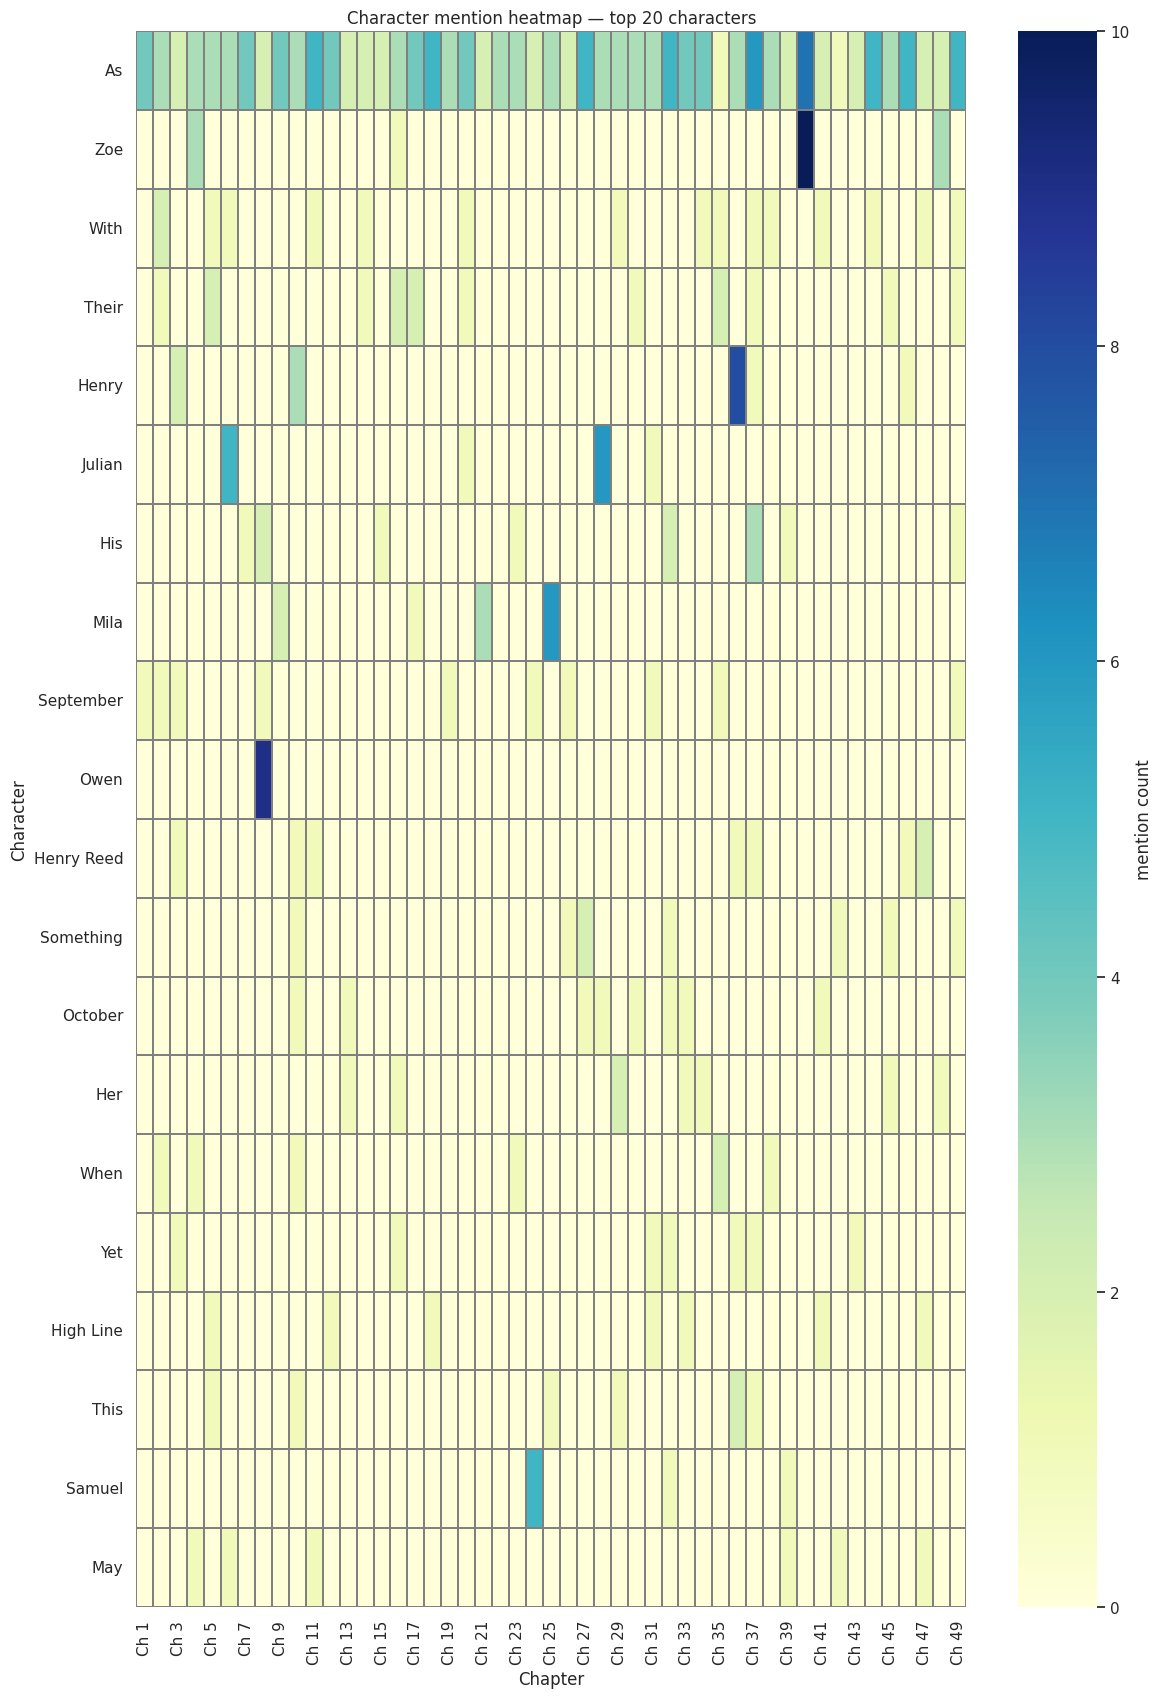

Saved: /content/qwen_run_outputs/story_analysis/character_mention_heatmap.png


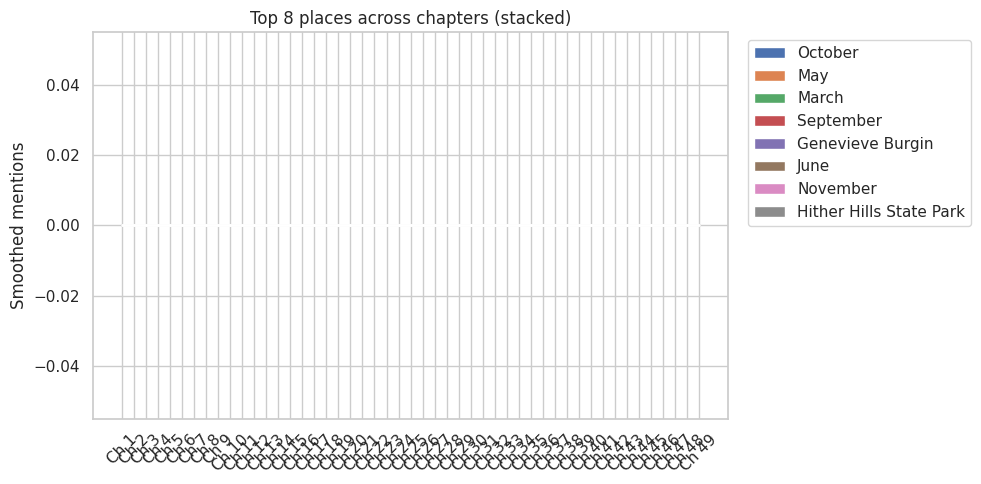

Saved: /content/qwen_run_outputs/story_analysis/places_stacked_area.png


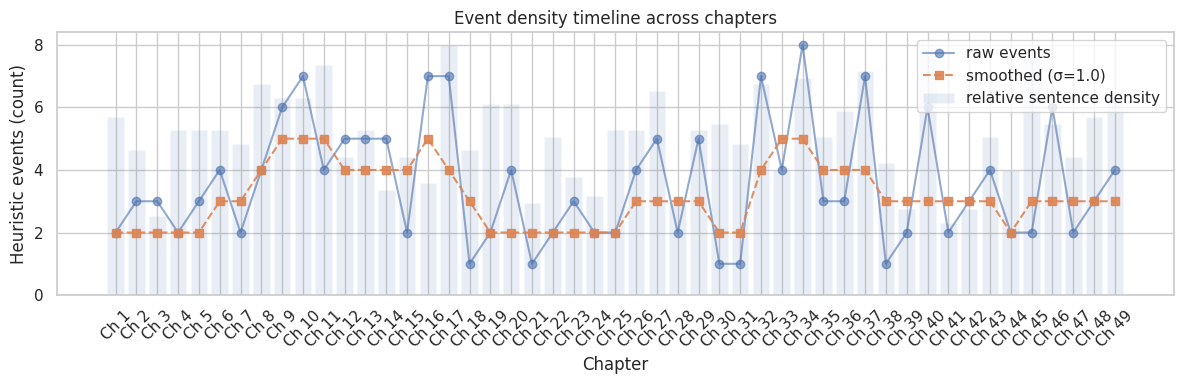

Saved: /content/qwen_run_outputs/story_analysis/event_density_timeline.png

Top chapters by heuristic event count:
 chap_no  sentences  proper_noun_mentions  place_mentions  date_mentions  heuristic_events  events_per_sentence
      34         33                    19               1              2                 8             0.242424
      10         30                    28               2              2                 7             0.233333
      16         17                    16               2              2                 7             0.411765
      32         32                    22               1              2                 7             0.218750
      17         38                    21               0              2                 7             0.184211
      37         34                    26               1              2                 7             0.205882
      40         37                    32               1              2                 6           

In [ ]:
# ===== timeline_visualizations.py (run in Colab) =====
import os, re, json
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

sns.set(style="whitegrid", font_scale=1.0)

# --- Config / paths ---
BOOK_TXT = "/content/output_book.txt"
OUT_DIR = "/content/qwen_run_outputs/story_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

# Developer-provided uploaded paper (local path available in session)
PAPER_PDF_PATH = "/mnt/data/2501.13121v1 Episodic Memory research paper.pdf"
print("Reference paper local path:", PAPER_PDF_PATH)

# Tuning
TOP_N_CHARACTERS = 20
TOP_N_PLACES = 8
SMOOTH_SIGMA = 1.0  # smoothing for timeline curve

# --- Lightweight NLP helpers (heuristics) ---
_sent_split_re = re.compile(r'(?<=[.!?])\s+')
_proper_seq_re = re.compile(r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b')
_place_re = re.compile(r'\b(?:in|at|on|to|near|from|towards|inside|outside|along)\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,4})\b')
_year_re = re.compile(r'\b(1[89]\d{2}|20\d{2})\b')
_month_day_re = re.compile(r'\b(?:\d{1,2}(?:st|nd|rd|th)?\s+)?(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}(?:st|nd|rd|th)?(?:,?\s*\d{4})?\b', re.I)
_ignore_set = {"The","A","An","It","He","She","They","We","I","In","On","At","From","To","Of","And","But","If","However","Chapter","Scene","Act","Prologue","Epilogue"}

def split_sentences(text):
    text = re.sub(r'\s+', ' ', str(text)).strip()
    if not text:
        return []
    return [s.strip() for s in _sent_split_re.split(text) if s.strip()]

def extract_proper_nouns(sentence):
    cands = _proper_seq_re.findall(sentence)
    out = []
    for cand in cands:
        first = cand.split()[0]
        if first in _ignore_set:
            continue
        out.append(cand.strip())
    return out

def extract_places(sentence):
    return [m.group(1).strip() for m in _place_re.finditer(sentence)]

def extract_dates(sentence):
    dates = []
    for m in _month_day_re.finditer(sentence):
        dates.append(m.group(0))
    for m in _year_re.finditer(sentence):
        dates.append(m.group(1))
    return dates

# --- Read book and split chapters ---
if not Path(BOOK_TXT).exists():
    raise FileNotFoundError(f"Book not found at {BOOK_TXT}. Upload output_book.txt first.")

book_raw = Path(BOOK_TXT).read_text(encoding="utf-8")
# Split by "Chapter <num>" headings; keep heading as marker
chap_splits = re.split(r'(?=(?:Chapter|CHAPTER)\s*\d+)', book_raw)
# If the first element doesn't start with Chapter, assume it is preface; index from 1 for chapters
chapters = []
for piece in chap_splits:
    txt = piece.strip()
    if not txt:
        continue
    # find chapter number
    m = re.match(r'(?:Chapter|CHAPTER)\s*(\d+)', txt, re.I)
    if m:
        chap_no = int(m.group(1))
        # remove the 'Chapter N' title prefix for cleaner text
        body = re.sub(r'^(?:Chapter|CHAPTER)\s*\d+\s*[:.-]?\s*', '', txt, count=1, flags=re.I).strip()
    else:
        # fallback: assign incremental chapter index if unlabeled
        chap_no = len(chapters)+1
        body = txt
    chapters.append({"chap_no": chap_no, "text": body})

# sort by chap_no (in case split was unordered)
chapters = sorted(chapters, key=lambda x: x["chap_no"])
n_chapters = len(chapters)
print(f"Detected {n_chapters} chapters.")

# --- Extract sentence-level info per chapter ---
chapter_stats = []
# character × chapter counts
char_counts_by_chapter = defaultdict(lambda: [0]*n_chapters)
place_counts_by_chapter = defaultdict(lambda: [0]*n_chapters)

for idx, ch in enumerate(chapters):
    txt = ch["text"]
    sents = split_sentences(txt)
    sent_count = len(sents)
    pn_total = 0
    place_total = 0
    date_total = 0
    events_total = 0  # heuristically treat sentence with a proper noun + verb as event
    for s in sents:
        pns = extract_proper_nouns(s)
        pls = extract_places(s)
        dts = extract_dates(s)
        pn_total += len(pns)
        place_total += len(pls)
        date_total += len(dts)
        # record per-character mention
        for pn in pns:
            char_counts_by_chapter[pn][idx] += 1
        for pl in pls:
            place_counts_by_chapter[pl][idx] += 1
        # simple event heuristic: proper noun + a verb (very light)
        if pns and re.search(r'\b(is|was|were|met|arrived|left|saw|noticed|said|asked|told|ran|walked|attended|performed|exhibited|studied|noticed|found|helped|seemed|entered|left|spoke|spoke to|spoke with)\b', s, re.I):
            events_total += 1
    chapter_stats.append({
        "chap_no": ch["chap_no"],
        "sentences": sent_count,
        "proper_noun_mentions": pn_total,
        "place_mentions": place_total,
        "date_mentions": date_total,
        "heuristic_events": events_total
    })

stats_df = pd.DataFrame(chapter_stats).sort_values("chap_no").reset_index(drop=True)
stats_df['events_per_sentence'] = stats_df['heuristic_events'] / stats_df['sentences'].replace(0, np.nan)

# --- Top characters and places (prune common noise) ---
# filter character names that are obviously not characters (like single common words) by selecting top counts
total_char_counts = {k: sum(v) for k, v in char_counts_by_chapter.items()}
top_chars = [k for k,_ in sorted(total_char_counts.items(), key=lambda x: -x[1])[:TOP_N_CHARACTERS]]
# prune trivial tokens (short single word with lowercase? keep heuristics light)
top_places = [k for k,_ in sorted({k:sum(v) for k,v in place_counts_by_chapter.items()}.items(), key=lambda x: -x[1])[:TOP_N_PLACES]]

# Build a matrix for heatmap: chapters × characters
char_matrix = pd.DataFrame({c: char_counts_by_chapter[c] for c in top_chars}, index=[f"Ch {c['chap_no']}" for c in chapters])

# Build place DataFrame (chapters × places)
place_matrix = pd.DataFrame({p: place_counts_by_chapter[p] for p in top_places}, index=[f"Ch {c['chap_no']}" for c in chapters])

# --- Plot 1: Character mention heatmap (chapters × top characters) ---
plt.figure(figsize=(max(8, 0.6*len(top_chars)), max(6, 0.35*n_chapters)))
sns.heatmap(char_matrix.T, cmap="YlGnBu", linewidths=0.3, linecolor='gray', cbar_kws={'label': 'mention count'})
plt.title(f"Character mention heatmap — top {len(top_chars)} characters")
plt.xlabel("Chapter")
plt.ylabel("Character")
plt.tight_layout()
heatmap_path = os.path.join(OUT_DIR, "character_mention_heatmap.png")
plt.savefig(heatmap_path, dpi=200)
plt.show()
print("Saved:", heatmap_path)

# --- Plot 2: Place stacked area across chapters (top places) ---
if not place_matrix.empty:
    place_df = place_matrix.copy()
    # smooth a bit
    for col in place_df.columns:
        place_df[col] = gaussian_filter1d(place_df[col], sigma=SMOOTH_SIGMA, mode='nearest')
    plt.figure(figsize=(10,5))
    x = np.arange(1, len(place_df)+1)
    plt.stackplot(x, [place_df[c] for c in place_df.columns], labels=place_df.columns)
    plt.xticks(x, [f"Ch {c['chap_no']}" for c in chapters], rotation=45)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02,1))
    plt.title(f"Top {len(place_df.columns)} places across chapters (stacked)")
    plt.ylabel("Smoothed mentions")
    plt.tight_layout()
    area_path = os.path.join(OUT_DIR, "places_stacked_area.png")
    plt.savefig(area_path, dpi=200)
    plt.show()
    print("Saved:", area_path)
else:
    print("No place mentions found to build stacked area.")

# --- Plot 3: Event density timeline (heuristic events per chapter) ---
plt.figure(figsize=(12,4))
x = stats_df['chap_no']
y = stats_df['heuristic_events']
y_smooth = gaussian_filter1d(y, sigma=SMOOTH_SIGMA, mode='nearest')
plt.plot(x, y, marker='o', linestyle='-', alpha=0.6, label="raw events")
plt.plot(x, y_smooth, marker='s', linestyle='--', alpha=0.9, label=f"smoothed (σ={SMOOTH_SIGMA})")
plt.bar(x, stats_df['sentences']/stats_df['sentences'].max()*max(y.max(),1), alpha=0.12, label="relative sentence density")
plt.xticks(x, [f"Ch {i}" for i in x], rotation=45)
plt.xlabel("Chapter")
plt.ylabel("Heuristic events (count)")
plt.title("Event density timeline across chapters")
plt.legend(loc='upper right')
plt.tight_layout()
timeline_path = os.path.join(OUT_DIR, "event_density_timeline.png")
plt.savefig(timeline_path, dpi=200)
plt.show()
print("Saved:", timeline_path)

# --- Print summary table (top chapters by events) ---
print("\nTop chapters by heuristic event count:")
print(stats_df.sort_values("heuristic_events", ascending=False).head(10).to_string(index=False))

# Save stats_df for downstream use
stats_csv = os.path.join(OUT_DIR, "chapter_event_stats.csv")
stats_df.to_csv(stats_csv, index=False)
print("Saved chapter stats CSV:", stats_csv)

Reference paper (local path): /mnt/data/2501.13121v1 Episodic Memory research paper.pdf


/tmp/ipython-input-3614285284.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


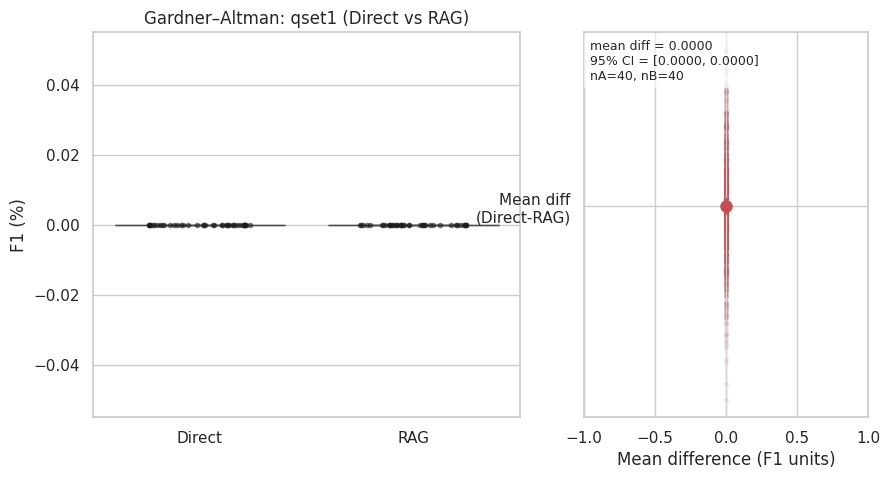

Saved plot for qset1 -> /content/eval_results/gardner_altman_qset1.png


/tmp/ipython-input-3614285284.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


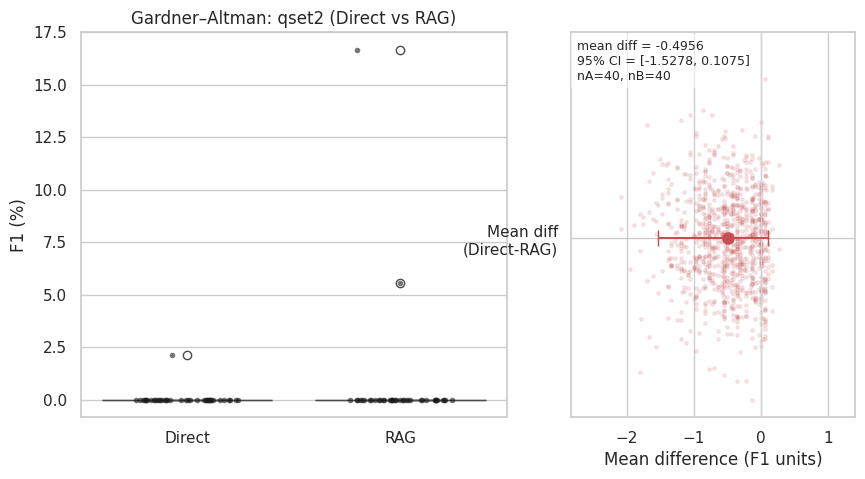

Saved plot for qset2 -> /content/eval_results/gardner_altman_qset2.png


ValueError: zero-size array to reduction operation fmax which has no identity

In [ ]:
# ===== gardner_altman_plots.py =====
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence, Tuple

sns.set(style="whitegrid", font_scale=1.0)

EVAL_DIR = "/content/eval_results"
OUT_DIR = EVAL_DIR
os.makedirs(OUT_DIR, exist_ok=True)

# Local path to uploaded paper (provided from your session)
PAPER_PATH = "/mnt/data/2501.13121v1 Episodic Memory research paper.pdf"
print("Reference paper (local path):", PAPER_PATH)

# --- helpers ---
def load_eval_files(eval_dir: str):
    """Return dict key->df for *_evaluation.csv files found in eval_dir."""
    files = sorted(glob.glob(os.path.join(eval_dir, "*_evaluation.csv")))
    dfs = {}
    for f in files:
        key = os.path.basename(f).replace("_evaluation.csv","")
        try:
            df = pd.read_csv(f)
            # normalize columns to lowercase
            df.columns = [c.lower().strip() for c in df.columns]
            dfs[key] = df
        except Exception as e:
            print("Skipping", f, "->", e)
    return dfs

def get_f1_by_method(df: pd.DataFrame, method_label: str) -> np.ndarray:
    """Return array of per-question f1_tok for a method in a combined df that may include 'method' column.
       If the provided df already is the per-file df for a method, then just read f1_tok column.
    """
    # prefer 'f1_tok' column
    f1_col = None
    for cand in ['f1_tok','f1','f1_score','mean_token_f1']:
        if cand in df.columns:
            f1_col = cand; break
    if f1_col is None:
        raise ValueError("No F1-like column found in DataFrame.")
    # If df contains a 'method' column, filter by it
    if 'method' in df.columns:
        arr = pd.to_numeric(df.loc[df['method']==method_label, f1_col], errors='coerce').dropna().to_numpy()
    else:
        # assume entire df corresponds to the method
        arr = pd.to_numeric(df[f1_col], errors='coerce').dropna().to_numpy()
    return arr

def bootstrap_mean_diff(a: Sequence[float], b: Sequence[float], n_boot=5000, seed=42) -> Tuple[float,float,float]:
    """Bootstrap mean difference (a_mean - b_mean). Returns (mean_diff, ci_low, ci_high)."""
    rng = np.random.default_rng(seed)
    a = np.asarray(a)
    b = np.asarray(b)
    n = max(len(a), len(b))
    # handle case where n==0
    if len(a)==0 or len(b)==0:
        return (np.nan, np.nan, np.nan)
    diffs = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())
    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return mean_diff, ci_low, ci_high

def gardner_altman_plot(a_vals, b_vals, a_label, b_label, title, outpath, annotate=True):
    """
    Create a Gardner-Altman style plot:
    - left: scatter/violin of the two groups
    - right: difference axis with mean diff and bootstrap CI
    """
    # convert to numeric arrays
    a = np.asarray(a_vals)
    b = np.asarray(b_vals)

    # convert to percentages if values are in 0..1 (makes axis friendlier)
    scale_to_pct = False
    if np.nanmax(np.concatenate([a, b])) <= 1.0:
        a = a * 100
        b = b * 100
        scale_to_pct = True

    # bootstrap mean diff
    mean_diff, ci_low, ci_high = bootstrap_mean_diff(a, b, n_boot=5000)

    # figure layout
    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 0.8], wspace=0.18)

    # left panel: strip + box
    ax0 = fig.add_subplot(gs[0,0])
    # combine into long df for seaborn plotting
    plot_df = pd.DataFrame({
        'value': np.concatenate([a, b]),
        'group': [a_label]*len(a) + [b_label]*len(b)
    })
    sns.boxplot(x='group', y='value', data=plot_df, whis=1.5, ax=ax0, showcaps=True, boxprops=dict(alpha=0.6))
    sns.stripplot(x='group', y='value', data=plot_df, ax=ax0, color='k', size=4, jitter=0.25, alpha=0.6)
    ax0.set_title(title)
    ax0.set_ylabel("F1 (%)" if scale_to_pct else "F1")
    ax0.set_xlabel("")

    # right panel: difference plot
    ax1 = fig.add_subplot(gs[0,1])
    # y coords for the difference dot
    y_center = 0.5
    ax1.axvline(0, color='lightgray', linewidth=1)
    # plot mean diff as a point with errorbar (CI)
    ax1.errorbar(mean_diff, y_center, xerr=[[mean_diff - ci_low], [ci_high - mean_diff]], fmt='o', color='C3', markersize=8, capsize=6)
    # add a swarm of bootstrap diffs for visual density? (smaller opacity)
    # recompute bootstrap sample diffs for plotting
    rng = np.random.default_rng(123)
    n_boot_plot = 1000
    boot_diffs = []
    for _ in range(n_boot_plot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        boot_diffs.append(sa.mean() - sb.mean())
    ax1.scatter(boot_diffs, np.random.normal(y_center, 0.03, size=len(boot_diffs)), s=6, alpha=0.12, color='C3')
    # annotate numeric values
    ax1.set_yticks([y_center])
    ax1.set_yticklabels([f"Mean diff\n({a_label}-{b_label})"])
    ax1.set_xlim(min(ci_low, mean_diff) - abs(mean_diff)*0.6 - 1, max(ci_high, mean_diff) + abs(mean_diff)*0.6 + 1)
    ax1.set_xlabel("Mean difference (F1 units)")
    if annotate:
        txt = f"mean diff = {mean_diff:.4f}\n95% CI = [{ci_low:.4f}, {ci_high:.4f}]\nnA={len(a)}, nB={len(b)}"
        ax1.text(0.02, 0.98, txt, transform=ax1.transAxes, ha='left', va='top', fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    return mean_diff, ci_low, ci_high

# --- load dfs ---
dfs = load_eval_files(EVAL_DIR)
if not dfs:
    raise FileNotFoundError("No *_evaluation.csv files found in " + EVAL_DIR)

# Expect keys like: qset1_direct_answers, qset1_rag_answers, qset2_direct_answers, etc.
# We'll pair direct vs rag per qset by matching prefixes (qset1, qset2, qset3).
prefixes = sorted(set(k.split("_")[0] for k in dfs.keys()))

results_summary = []

for pref in prefixes:
    direct_key = None
    rag_key = None
    # find keys that start with prefix and contain 'direct' or 'rag'
    for k in dfs.keys():
        if k.startswith(pref):
            if 'direct' in k:
                direct_key = k
            elif 'rag' in k:
                rag_key = k
    if direct_key is None or rag_key is None:
        print(f"Skipping {pref}: missing direct or rag file (direct={direct_key}, rag={rag_key})")
        continue

    df_direct = dfs[direct_key]
    df_rag = dfs[rag_key]

    # extract per-question F1 values (try columns f1_tok or f1)
    def extract_f1_arr(df):
        for cand in ['f1_tok','f1','f1_score','mean_token_f1']:
            if cand in df.columns:
                arr = pd.to_numeric(df[cand], errors='coerce').dropna().to_numpy()
                return arr
        return np.array([])

    a = extract_f1_arr(df_direct)
    b = extract_f1_arr(df_rag)

    outpath = os.path.join(OUT_DIR, f"gardner_altman_{pref}.png")
    title = f"Gardner–Altman: {pref} (Direct vs RAG)"
    md, cl, ch = gardner_altman_plot(a, b, "Direct", "RAG", title, outpath)
    results_summary.append({'set': pref, 'mean_diff': md, 'ci_low': cl, 'ci_high': ch, 'n_direct': len(a), 'n_rag': len(b)})
    print(f"Saved plot for {pref} -> {outpath}")

# Also build a combined ALL Direct vs ALL RAG plot (aggregate across sets)
all_a = []
all_b = []
for k,v in dfs.items():
    if 'direct' in k:
        # extract f1
        for cand in ['f1_tok','f1','f1_score','mean_token_f1']:
            if cand in v.columns:
                arr = pd.to_numeric(v[cand], errors='coerce').dropna().to_numpy()
                all_a.append(arr)
                break
    if 'rag' in k:
        for cand in ['f1_tok','f1','f1_score','mean_token_f1']:
            if cand in v.columns:
                arr = pd.to_numeric(v[cand], errors='coerce').dropna().to_numpy()
                all_b.append(arr)
                break

if all_a and all_b:
    all_a = np.concatenate(all_a)
    all_b = np.concatenate(all_b)
    outpath_all = os.path.join(OUT_DIR, "gardner_altman_ALL_direct_vs_ALL_rag.png")
    md, cl, ch = gardner_altman_plot(all_a, all_b, "Direct_all", "RAG_all", "Gardner–Altman: All Direct vs All RAG", outpath_all)
    results_summary.append({'set': 'ALL', 'mean_diff': md, 'ci_low': cl, 'ci_high': ch, 'n_direct': len(all_a), 'n_rag': len(all_b)})
    print("Saved combined ALL plot ->", outpath_all)
else:
    print("Insufficient data to build combined ALL plot.")

# Print results summary
print("\nSummary of mean differences (Direct - RAG):")
print(pd.DataFrame(results_summary).round(6).to_string(index=False))

# Print path to paper for your records (as requested by session)
print("\nEpisodic Memory paper path (local):", PAPER_PATH)